# D3: Query Answering Machine

Id | Category     | Value | Description 
--|:---------:|:-----------:|:-----------:
1|Name      | <i><b>Eric Gao | I'm working alone
2|Andrew ID   | <i><b>jingxia3 | My Andrew ID
3|Project Name | <i><b>Feeling Artsy | Extracting human emotions with CV techniques

Below are some general things I've tried before you see what's in this document:

1. I initially used 4 classes. The accuracy are the same as random guessing. I merged image classes to increase the sample size for each class. <br>

1. I initially had only 9 features. The training outcomes are not so ideal. I used polynomial features of them. <br>

1. I initially had very small estimators for ensemble, resulting in poor testing accuracy for Random Forest. I made the estimator larger. <br>

1. I initially had a big gap for CNN. I reduced batch size and increased epochs.

In this section, I chose the following models for my classification task:
* kNN
* Random Forest
* Convolutional Neural Network

## D3.1: Process Iterations

I first changed the kernal to DataPreparation kernal to migrate the prepared dataset to here.

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 71 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           805 non-null    object 
 1   image        805 non-null    object 
 2   red          805 non-null    object 
 3   green        805 non-null    object 
 4   blue         805 non-null    object 
 5   rvar         805 non-null    float64
 6   gvar         805 non-null    float64
 7   bvar         805 non-null    float64
 8   rskew        805 non-null    float64
 9   gskew        805 non-null    float64
 10  bskew        805 non-null    float64
 11  rkurt        805 non-null    float64
 12  gkurt        805 non-null    float64
 13  bkurt        805 non-null    float64
 14  1            805 non-null    float64
 15  rvar         805 non-null    float64
 16  gvar         805 non-null    float64
 17  bvar         805 non-null    float64
 18  rskew        805 non-null    float64
 19  gskew   

In [113]:
hogdf = pd.DataFrame([np.hstack(i) for i in df['HOG']])
hogdf.shape,hogdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Columns: 10000 entries, 0 to 9999
dtypes: float64(10000)
memory usage: 61.4 MB


((805, 10000), None)

In [114]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### Iteration 1: KNN

We humans often see emotions in images by relating them to similar images. For example, when looking at something with very bright colors, we might think it's happy because it relates to the fireworks we see.

As such, K Nearest Neighbors (KNN) model can be applied to perform this classification task. It is a non-parametric model that classifies data by considering its k closest neighbors. It falls under the supervised learning category, so our label can be useful.

Below I define some basic functions and import some libraries.

In [115]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def learn_kNN_classifier(features_data, targets, neighbors, voting):
    '''Set up a K-NN classifier and fits it to the given training data.
       Return: learned classifier.''' 
    
    classifier = KNeighborsClassifier(n_neighbors=neighbors, 
                                      weights=voting
                                      )
    classifier.fit(features_data, targets)
    
    return classifier

Below I define features and labels for training

In [116]:
features = pd.concat([df.iloc[:,5:69],hogdf],axis=1)
labels = df['label']
features.columns = features.columns.astype(str)

Below I use cross-validation to find the best k for kNN.

In [117]:
from sklearn import metrics

k_fold = 10

for k in [2,3,4,5,6,7,8,9]:

    classifier = learn_kNN_classifier(features, 
                                      labels, 
                                      k, 
                                      'uniform')

    # if not specified either, K-Fold is the default CV method
    # and the cv argument specifies the number of foldings
    cv_results = cross_validate(classifier, features, labels, 
                                cv=k_fold,
                                return_train_score=True)

    print('[{}-NN] Mean test score: {:.3f} (std: {:.3f})'
          '\nMean train score: {:.3f} (std: {:.3f})\n'.format(k,
                                                  np.mean(cv_results['test_score']),
                                                  np.std(cv_results['test_score']),
                                                  np.mean(cv_results['train_score']),
                                                  np.std(cv_results['train_score'])))

[2-NN] Mean test score: 0.607 (std: 0.071)
Mean train score: 0.876 (std: 0.009)

[3-NN] Mean test score: 0.617 (std: 0.072)
Mean train score: 0.841 (std: 0.008)

[4-NN] Mean test score: 0.597 (std: 0.065)
Mean train score: 0.775 (std: 0.011)

[5-NN] Mean test score: 0.629 (std: 0.050)
Mean train score: 0.766 (std: 0.010)

[7-NN] Mean test score: 0.610 (std: 0.061)
Mean train score: 0.740 (std: 0.013)

[8-NN] Mean test score: 0.583 (std: 0.059)
Mean train score: 0.728 (std: 0.015)

[9-NN] Mean test score: 0.590 (std: 0.056)
Mean train score: 0.708 (std: 0.011)



The accuracies are a bit low. As k=5 has relatively the highest test and train scores, I would go with k=5 as the best one. Below is the confusion matrix.

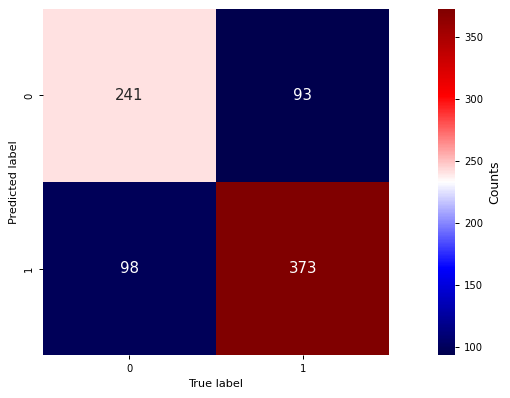

In [118]:
classifier = learn_kNN_classifier(features, 
                                  labels, 
                                  5, 
                                  'uniform')
Y_pred = classifier.predict(features)

from sklearn.metrics import confusion_matrix
import seaborn as sns

def show_confusion_matrix(true_labels, learned_labels, class_names):

    cmat = confusion_matrix(true_labels, learned_labels) 

    plt.figure(figsize=(14, 5))

    plt.tick_params(labelsize=8)

    
    hm = sns.heatmap(cmat.T, square=True, annot=True, fmt='d', cbar=True,
                     xticklabels=class_names,
                     yticklabels=class_names, 
                     cmap="seismic", 
                     annot_kws={"size":12}, cbar_kws={'label': 'Counts'})

    # this is to set the last axis of the figure, the colorbar in this case
    hm.figure.axes[-1].yaxis.label.set_size(10) # fontsize of bar label
    hm.figure.axes[-1].tick_params(labelsize=8) # fontsize of ticks labels
    
    #plt.ylim(10, 0)

    plt.xlabel('True label', fontsize=9)
    plt.ylabel('Predicted label', fontsize=9)
    
    plt.show()

show_confusion_matrix(labels, Y_pred, [0, 1])

And because the low accuracy in both training and testing, this suggest that the model is too weak, and I'll considering using a stronger model.

Recall that there were around 350 images with class 0 and 450 images with class 1. It's expected that the model does better at recognizing class 1 images.

In sum, KNN seems to be doing a decent job with maximum accuracy around 0.67. Can we do better with another classifier?

### Iteration 2: Random Forest

Let's see what Random Forest does for us.

As we see form KNN (which was a weak model for the task), it's better to use ensemble method to increase the model complexity in order to achieve better performance.

Random Forest is such an ensemble method that uses a bunch of decision tree models. For a decision tree, each internal node contains a criteria for subdividing samples from its parents. On its leaves, there would be labels that correspond to outcomes. In this case, we use a classification tree.

In [278]:
from sklearn.tree import DecisionTreeClassifier

k_fold = 10
max_samples  = 0.3 # small sample size to reduce calculation
max_features = 0.7 # fewer features selected to increase diversity
n_estimators = 21 # that's how it's a forest

for depth in [5,7,9]:
    start = time.time()
    base = DecisionTreeClassifier(criterion='gini', max_depth=depth,
                                random_state=15288)
    classifier = BaggingClassifier(base, n_estimators=n_estimators,
                            max_samples=max_samples, max_features=max_features,
                            random_state=15288)

    cv_results = cross_validate(classifier, features, labels, 
                                cv=k_fold,
                                return_train_score=True)

    print('[Random Forest of depth {}] Mean test score: {:.3f} (std: {:.3f})'
          '\nMean train score: {:.3f} (std: {:.3f})'.format(depth,
                                                  np.mean(cv_results['test_score']),
                                                  np.std(cv_results['test_score']),
                                                  np.mean(cv_results['train_score']),
                                                  np.std(cv_results['train_score'])))
    print('Time elapsed: {:.2f} seconds\n'.format(time.time()-start))

[Random Forest of depth 5] Mean test score: 0.614 (std: 0.047)
Mean train score: 0.880 (std: 0.014)
Time elapsed: 88.45 seconds

[Random Forest of depth 7] Mean test score: 0.647 (std: 0.036)
Mean train score: 0.894 (std: 0.009)
Time elapsed: 99.60 seconds

[Random Forest of depth 9] Mean test score: 0.624 (std: 0.042)
Mean train score: 0.899 (std: 0.006)
Time elapsed: 102.45 seconds



After some cross validation, max depth of 7 seems to be the most optimal. Let's see its confusion matrix.

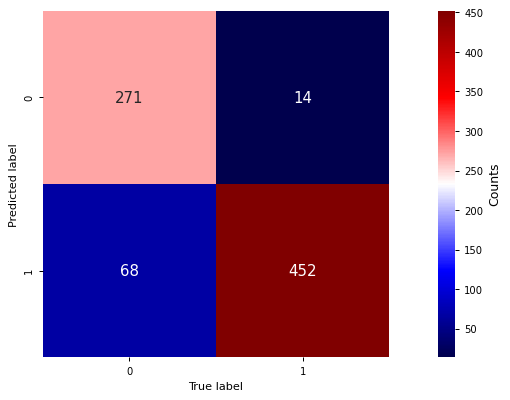

In [279]:
base = DecisionTreeClassifier(criterion='gini', max_depth=7,
                              random_state=15288)
classifier = BaggingClassifier(base, n_estimators=n_estimators,
                        max_samples=max_samples, max_features=max_features,
                        random_state=15288)
classifier.fit(features,labels)
Y_pred = classifier.predict(features)

show_confusion_matrix(labels, Y_pred, [0, 1])

For Random Forest, the confusion matrix looks a lot better than the kNN. However, the generalization error is around the same as that of kNN. Considering Decision Tree to be a more complex model than kNN, there might be risks of overfitting.

### Iteration 3: CNN

From the previous two attempts, we often find the model to be too weak to identify the subtle emotions in images.

Let's see if the all-powerful CNN create miracles. Convolutional Neural Network is commonly used for image related tasks, so I think it could be useful here.

In [128]:
import time
from time import process_time 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
tf.random.set_seed(15288)

In [129]:
model = Sequential()

# input layer
model.add(Conv2D(128,kernel_size=(7,7),input_shape=(100,100,3),activation='relu'))

# convolutional layer
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.2))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 94, 94, 128)       18944     
                                                                 
 conv2d_52 (Conv2D)          (None, 90, 90, 64)        204864    
                                                                 
 conv2d_53 (Conv2D)          (None, 88, 88, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 29, 29, 64)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 29, 29, 64)        0         
                                                                 
 flatten_13 (Flatten)        (None, 53824)             0         
                                                     

14 million parameters! Let's see how the model performs.

In [130]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['image'], df['label'], 
                                                    test_size=0.2, random_state=15288)
img_shape = (100, 100, 3)

X_train = np.array([x.reshape(img_shape) for x in X_train])
X_test = np.array([x.reshape(img_shape) for x in X_test])
Y_train = np_utils.to_categorical(Y_train, 2)
Y_test = np_utils.to_categorical(Y_test, 2)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((644, 100, 100, 3), (161, 100, 100, 3), (644, 2), (161, 2))

In [132]:
# Train
batch_size = 64
epochs = 20

start_time = time.process_time()
        
training = model.fit(X_train, Y_train, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     validation_data=(X_test,Y_test),
                     verbose=2)
    
print('\n\nTraining time: {:.3f} sec\n'.format(time.process_time() - start_time))

score = model.evaluate(X_test, Y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
11/11 - 22s - loss: 20.7779 - accuracy: 0.4783 - val_loss: 0.8017 - val_accuracy: 0.4037 - 22s/epoch - 2s/step
Epoch 2/20
11/11 - 20s - loss: 0.7144 - accuracy: 0.5093 - val_loss: 0.6915 - val_accuracy: 0.5652 - 20s/epoch - 2s/step
Epoch 3/20
11/11 - 19s - loss: 0.6889 - accuracy: 0.5745 - val_loss: 0.6839 - val_accuracy: 0.5963 - 19s/epoch - 2s/step
Epoch 4/20
11/11 - 14s - loss: 0.6838 - accuracy: 0.5745 - val_loss: 0.6757 - val_accuracy: 0.5963 - 14s/epoch - 1s/step
Epoch 5/20
11/11 - 14s - loss: 0.7055 - accuracy: 0.5699 - val_loss: 0.6769 - val_accuracy: 0.5901 - 14s/epoch - 1s/step
Epoch 6/20
11/11 - 14s - loss: 0.6820 - accuracy: 0.5761 - val_loss: 0.6784 - val_accuracy: 0.5901 - 14s/epoch - 1s/step
Epoch 7/20
11/11 - 14s - loss: 0.6804 - accuracy: 0.5761 - val_loss: 0.6774 - val_accuracy: 0.5901 - 14s/epoch - 1s/step
Epoch 8/20
11/11 - 14s - loss: 0.6816 - accuracy: 0.5761 - val_loss: 0.6790 - val_accuracy: 0.5839 - 14s/epoch - 1s/step
Epoch 9/20
11/11 - 14s - loss: 

Stored information: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


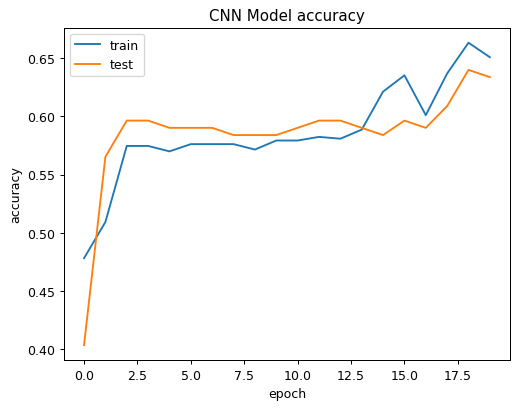

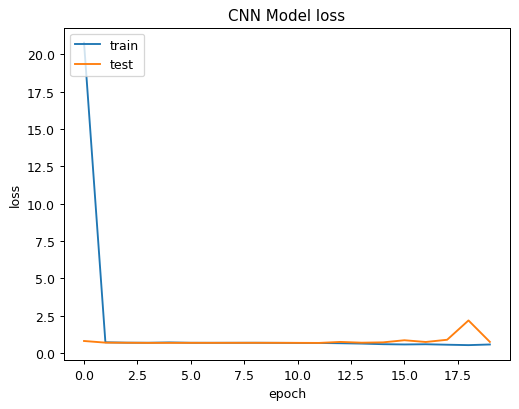

In [133]:
def show_learning_curves(learning_evolution, title=''):

    # list all data stored in the learning_evolution object
    print('Stored information:', [h for h in learning_evolution.history.keys()])

    # show evolution of accuracy
    plt.plot(learning_evolution.history['accuracy'])

    # show evolution of cross-validated accuracy
    if 'val_accuracy' in learning_evolution.history:
        plt.plot(learning_evolution.history['val_accuracy'])

    plt.title(title + ' Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # show evolution of loss
    plt.plot(learning_evolution.history['loss'])
    
     # show evolution of cross-validated loss
    if 'val_accuracy' in learning_evolution.history:
        plt.plot(learning_evolution.history['val_loss'])

    plt.title(title + ' Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
show_learning_curves(training, 'CNN')

The model seems to have needed more training time. It might be a good idea to increase the number of epochs.

In [134]:
from keras.models import Model

def display_activation(activations, activation_index, 
                       ncols = 5, 
                       size=(12, 12), reshape=None): 
    
    activation = activations[activation_index]

    print('Shape of layer: ', activation.shape)
    
    if len(activation.shape) > 2:
        total_fmaps = activation.shape[-1] # the last axis of the array
        nrows = int(np.ceil(total_fmaps / ncols))
    else:
        total_fmaps = 1
        nrows,ncols = (1,1)

    feature_map=0
    
    if (ncols, nrows) == (1,1):
        plt.yticks([], [])
        plt.xticks(fontsize=6)
        if reshape == None:
            plt.imshow(activation[0].reshape(-1,1).T) #cmap='gray')
        else:
            plt.imshow(activation[0].reshape(reshape).T)
        return
        
    #fig, subplot = plt.subplots(nrows, ncols, figsize=size)
    fig = plt.figure(figsize=size)
    fig.subplots_adjust(hspace=0.23, wspace=0.22)
    
    for row in range(nrows):
        for col in range(ncols):
            subplot = fig.add_subplot(nrows, ncols, feature_map+1) 
            #subplot[row][col].imshow(activation[0, :, :, feature_map], 
            #                         cmap='gray')
            #subplot[row][col].tick_params(labelsize = 3)
            subplot.imshow(activation[0, :, :, feature_map])# cmap='gray')
            subplot.tick_params(labelsize = 3)    
            
            feature_map += 1
            if feature_map == total_fmaps:
                return

In [135]:
layer_outputs = [layer.output for layer in model.layers]

layer_names = [layer.name.split('_')[0] for layer in model.layers]

#print(layer_outputs)

activation_model = Model(inputs=model.input, outputs=layer_outputs)

img_index = 9

img_sample = X_train[img_index].reshape(1, *img_shape)

activations = activation_model.predict(img_sample)

for a,_ in enumerate(activations):
    print('Activation Layer [{}]: {} {}'.format(a, layer_names[a],
                                                activations[a].shape))

1/1 [==============================] - 0s 78ms/step
Activation Layer [0]: conv2d (1, 94, 94, 128)
Activation Layer [1]: conv2d (1, 90, 90, 64)
Activation Layer [2]: conv2d (1, 88, 88, 64)
Activation Layer [3]: max (1, 29, 29, 64)
Activation Layer [4]: dropout (1, 29, 29, 64)
Activation Layer [5]: flatten (1, 53824)
Activation Layer [6]: dense (1, 256)
Activation Layer [7]: dense (1, 128)
Activation Layer [8]: dense (1, 128)
Activation Layer [9]: dense (1, 128)
Activation Layer [10]: dense (1, 64)
Activation Layer [11]: dropout (1, 64)
Activation Layer [12]: dense (1, 2)


Type of layer:  conv2d
Shape of layer:  (1, 90, 90, 64)


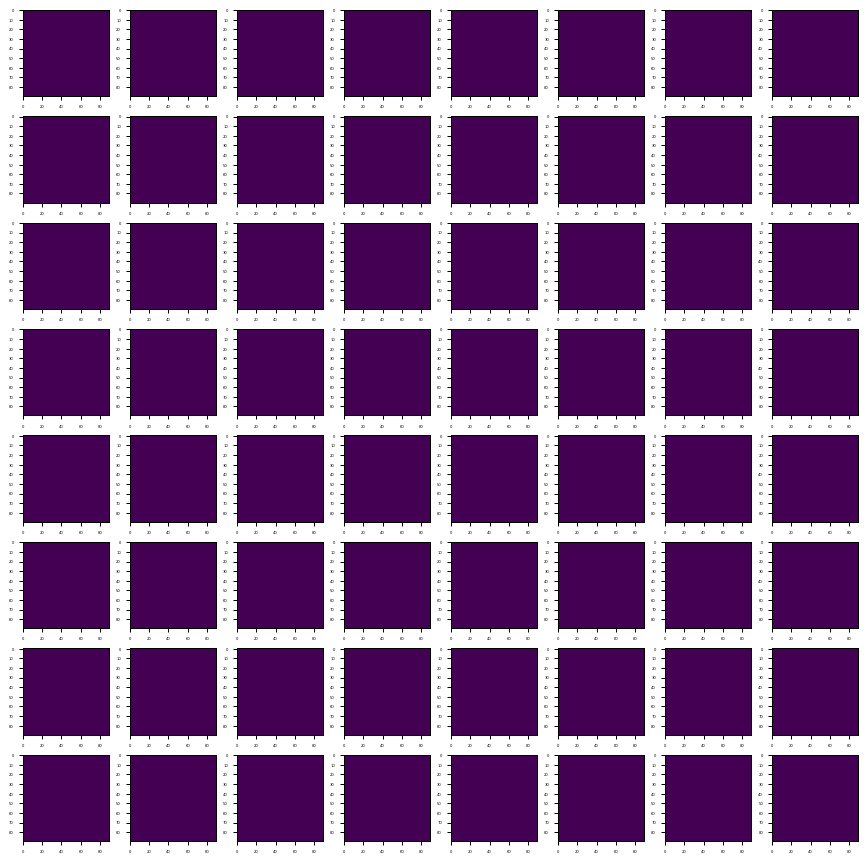

In [136]:
print('Type of layer: ', layer_names[1])
display_activation(activations, 1, 8)

Many of these feature maps don't have anything... Maybe we can reduce the model?

In [357]:
model = Sequential()

# input + convolutional layer
model.add(Conv2D(128,kernel_size=(7,7),input_shape=(100,100,3),activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(7,7), activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(16, kernel_size=(5,5), activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2)))

# flatten + dense + output layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_347 (Conv2D)         (None, 94, 94, 128)       18944     
                                                                 
 dropout_295 (Dropout)       (None, 94, 94, 128)       0         
                                                                 
 conv2d_348 (Conv2D)         (None, 90, 90, 64)        204864    
                                                                 
 dropout_296 (Dropout)       (None, 90, 90, 64)        0         
                                                                 
 conv2d_349 (Conv2D)         (None, 88, 88, 32)        18464     
                                                                 
 dropout_297 (Dropout)       (None, 88, 88, 32)        0         
                                                                 
 max_pooling2d_123 (MaxPooli  (None, 44, 44, 32)     

Much fewer parameters! Let's see how it performs.

In [358]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, metrics=['accuracy'])

In [359]:
from numpy.random import seed
seed(15288)
# Train
batch_size = 32
epochs = 50

start_time = time.process_time()
        
training = model.fit(X_train, Y_train, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     validation_data=(X_test,Y_test),
                     verbose=2)
    
print('\n\nTraining time: {:.3f} sec\n'.format(time.process_time() - start_time))

score = model.evaluate(X_test, Y_test, verbose=0) 

print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
21/21 - 16s - loss: 11.5805 - accuracy: 0.4907 - val_loss: 0.6843 - val_accuracy: 0.6273 - 16s/epoch - 752ms/step
Epoch 2/50
21/21 - 16s - loss: 0.7973 - accuracy: 0.4922 - val_loss: 0.6818 - val_accuracy: 0.6087 - 16s/epoch - 739ms/step
Epoch 3/50
21/21 - 16s - loss: 0.7170 - accuracy: 0.5683 - val_loss: 0.6696 - val_accuracy: 0.6398 - 16s/epoch - 754ms/step
Epoch 4/50
21/21 - 16s - loss: 0.7072 - accuracy: 0.5839 - val_loss: 0.6679 - val_accuracy: 0.6584 - 16s/epoch - 747ms/step
Epoch 5/50
21/21 - 16s - loss: 0.6754 - accuracy: 0.5963 - val_loss: 0.6755 - val_accuracy: 0.6025 - 16s/epoch - 747ms/step
Epoch 6/50
21/21 - 16s - loss: 0.6770 - accuracy: 0.5978 - val_loss: 0.6712 - val_accuracy: 0.6211 - 16s/epoch - 741ms/step
Epoch 7/50
21/21 - 16s - loss: 0.6715 - accuracy: 0.6320 - val_loss: 0.6660 - val_accuracy: 0.6211 - 16s/epoch - 755ms/step
Epoch 8/50
21/21 - 16s - loss: 0.6490 - accuracy: 0.6227 - val_loss: 0.6647 - val_accuracy: 0.6398 - 16s/epoch - 747ms/step
Epoch 9

Wow! Testing accuracy is over 75%! CNN is magic indeed!

Stored information: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


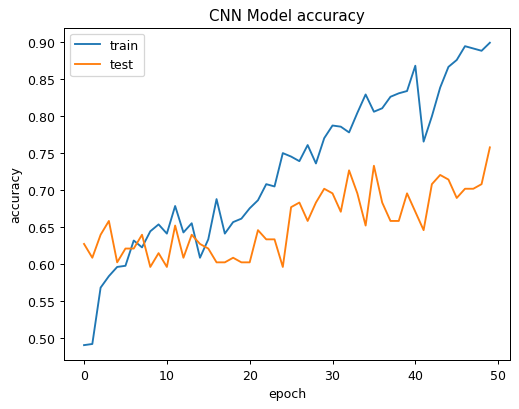

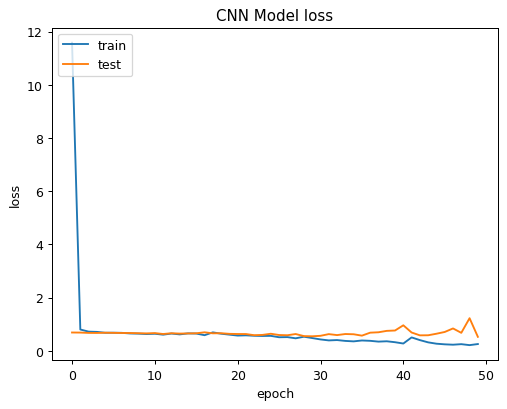

In [360]:
show_learning_curves(training, 'CNN')

The training curves look a bit stepwise? After 10 epochs, both training and testing accuracy begins to stablize, but the testing error starts to increase. There might be an overfitting happening. However, it is reasonable to say that CNN performed around 10% better than random forest.

Let's see its performance on training data!

21/21 [==============================] - 3s 134ms/step


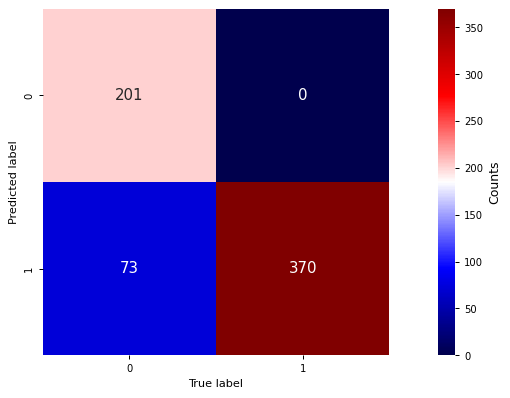

In [361]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_prediction = model.predict(X_train)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction, axis = 1)

# Convert test data to one hot vectors
Y_true = np.argmax(Y_train, axis = 1) 

show_confusion_matrix(Y_true, Y_pred_classes, [0, 1])

How about for testing data?

6/6 [==============================] - 1s 116ms/step


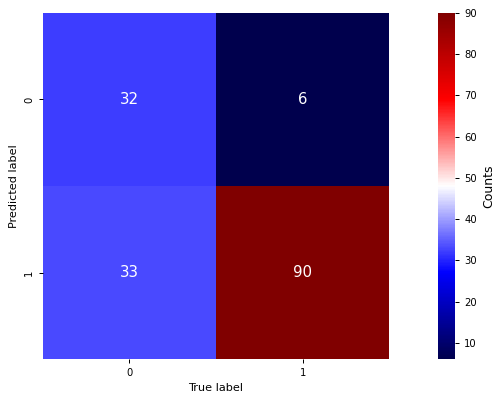

In [362]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_prediction = model.predict(X_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction, axis = 1)

# Convert test data to one hot vectors
Y_true = np.argmax(Y_test, axis = 1) 

show_confusion_matrix(Y_true, Y_pred_classes, [0, 1])

Not bad! We see that it rarely misclassify negative images as positive images, but sometimes misclassify positive images as negative ones.

### Final words

Id| Model         | Parameters| Training accuracy | Testing accuracy
--|:-------------:|:-----------:|:-----------:|:-----------:
1 |kNN            | neighbors=5, weights='distance'| 0.740 | 0.629
2 |Random Forest  | max_depth=7, criterion='gini', n_estimators = 21  | 0.894 | 0.647
3 |CNN            | (see model summary above, epoch 49) | 0.899 | 0.758

Clearly, CNN is the most optimal model for our task. Let's use it in the app!